In [1]:
import os
import h5py
import numpy as np
import pandas as pd
from collections import Counter

% matplotlib inline
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import LeaveOneOut
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import permutation_test_score

# loading data and preprocessing

In [2]:
voxels = pd.read_csv("fszstatcope2_nvoxels_nz.csv", index_col=0)
behav = pd.read_csv("behav.txt", sep='\t', index_col=0)
print(np.mean(behav.index == voxels.index)) #should be 1.0
voxels_g27 = voxels.iloc[:, (voxels.iloc[1,:] > 27).values]
remove_feature_idx = []

for idx, col in enumerate(voxels_g27.columns):
    for ss in ["Vent", "Stem", "Cerebellum", "CSF", "White", "plexus"]:
        if ss in col:
            remove_feature_idx.append(idx)
            
remove_feature_idx = np.unique(remove_feature_idx)
print(voxels_g27.shape[1] - remove_feature_idx.shape[0]) # should be 58
voxels_data = voxels_g27.iloc[:, np.setdiff1d(np.arange(voxels_g27.shape[1]), remove_feature_idx)]
roi_data = pd.read_csv("fszstatcope2_means_nz.csv", index_col=0).loc[:, voxels_data.columns]
print(np.all(roi_data.columns == voxels_data.columns)) # should be true

# validation set
vset_roi_data = pd.read_csv("fszstatcope2_means_nz_valset.csv", index_col=0).loc[:, voxels_data.columns]
vset_voxel_data = pd.read_csv("fszstatcope2_nvoxels_nz_valset.csv", index_col=0).loc[:, voxels_data.columns]
vbehav = pd.read_csv("valset_behav.csv", index_col=0)

roi2g = roi_data[np.logical_or(behav.young_kid == 1, behav.adult == 1)]
behav2g = behav[np.logical_or(behav.young_kid == 1, behav.adult == 1)]

1.0
58
True


# removing linear effect of covariates

In [3]:
def projection(data , covars):
    """for removing linear effect of covariates"""
    X, C = data.values, covars.values
    P = np.eye(C.shape[0]) - C.dot(np.linalg.pinv(C.T.dot(C))).dot(C.T)
    return pd.DataFrame(P.dot(X), columns=data.columns, index=data.index)

data = projection(roi2g, behav2g.loc[:, ["gender", "iq", "composite_motion"]])
vset_data = projection(vset_roi_data, vbehav.loc[:, ["sex","iq", "composite_motion"]])

# this defines the model that is run each time and some auxiliary functions

In [4]:
def random_forest_model(data, y, thresh, cv, clf, max_feat=10):
    X = data.values
    results = dict(pred=[], ytrue=[], fi=[], fidx=[])
    results_null = dict(pred=[], ytrue=[], fi=[], fidx=[])
    
    for idx, (train, test) in enumerate(cv.split(X, y)):
        sfm = SelectFromModel(clf, threshold=thresh)
        sfm.fit(X[train], y[train])
        n_features = sfm.transform(X[train]).shape[1]
        
        while n_features > max_feat:
            sfm.threshold += 0.01
            X_transform = sfm.transform(X[train])
            n_features = X_transform.shape[1]
        
        clf.fit(X_transform, y[train])
        results["pred"].append(clf.predict(sfm.transform(X[test])))
        results["ytrue"].append(y[test])
        results["fi"].append(clf.feature_importances_)
        results["fidx"].append(sfm.get_support())
        
        # this is to compute the null model
        try:
            y_shuff = np.copy(y[train])
            np.random.shuffle(y_shuff)
            clf.fit(X_transform, y_shuff)
            results_null["pred"].append(clf.predict(sfm.transform(X[test])))
            results_null["ytrue"].append(y[test])
            results_null["fi"].append(clf.feature_importances_)
            results_null["fidx"].append(sfm.get_support())
        except:
            print("couldn't compute null model")
        
    
    roc = roc_auc_score(np.array(results["ytrue"]).ravel(), np.array(results["pred"]).ravel())
    
    # this is to compute the null model
    try:
        roc_null = roc_auc_score(
            np.array(results_null["ytrue"]).ravel(),
            np.array(results_null["pred"]).ravel()
        )
    except:
        print("couldn't compute null roc score")
        
    return results, roc, results_null, roc_null

def h5_save(path, data_obj, dts):
    if len(data_obj) != len(dts):
        print("something is wrong")
        return None
    with h5py.File(path, "w") as data_store:
        for idx, (key, val) in enumerate(data_obj.items()):
            data_set = data_store.create_dataset(
                key, val.shape, dtype=dts[idx]
            )
            data_set[...] = val
    return path, data_obj.keys()
    
def h5_read(path, key):
    with h5py.File(path, "r") as file_store:
        data = file_store[key][...]
    return data

# to get the average score so that to rule out uncertainty for performance 

In [5]:
n_iters = 200 # arbitrary
N, P = data.shape
rocs = np.zeros(n_iters)
rocs_null = np.zeros(n_iters)
bools = np.full((n_iters, N, P), False, dtype=bool)
bools_null = np.full((n_iters, N, P), False, dtype=bool)
imps = np.zeros((n_iters, N, P))
imps_null = np.zeros((n_iters, N, P))
failed_idxs = []

class Storage(object):
    def __init__(self, name, feature_index, feature_importance, _n, _p):
        self.name = name
        self.feature_index = feature_index,
        self.feature_importance = feature_importance
        self._n = _n
        self._p = _p
        
    def make_bool_matrix(self):
        bool_mat = np.array(
            [self.feature_index[0][i] for 
            i in np.arange(len(self.feature_index[0]))]
        )
        return bool_mat
    
    def make_importance_matrix(self):
        bool_mat = self.make_bool_matrix()
        imp_mat = np.zeros((self._n, self._p))
        
        for idx in np.arange(self._n):
            non_zeros = np.where(bool_mat[idx, :])
            imp_mat[idx, non_zeros] = self.feature_importance[idx]
            
        return imp_mat
    
for idx in np.arange(n_iters):
    clf = RandomForestClassifier(n_estimators=1000) # arbitrary
    cv = LeaveOneOut() # arbitrary
    max_feat = 10 # arbitrary
    thresh = 0.01 # arbitrary
    
    try:
        res, roc, res_null, roc_null = random_forest_model(
            data, behav2g.young_kid.values, thresh, cv, clf, max_feat
        )
        rocs[idx], rocs_null[idx] = roc, roc_null
        s = Storage(
                idx, 
                res["fidx"],
                res["fi"],
                N, 
                P
        )
        s_null = Storage(
            idx,
            res_null["fidx"],
            res_null["fi"],
            N,
            P
        )
        bools[idx, :, :] = s.make_bool_matrix()
        imps[idx, :, :] = s.make_importance_matrix()
        bools_null[idx, :, :] = s_null.make_bool_matrix()
        imps_null[idx, :, :] = s_null.make_importance_matrix()
    except:
        print(idx)
        failed_idx.append(idx)
        pass

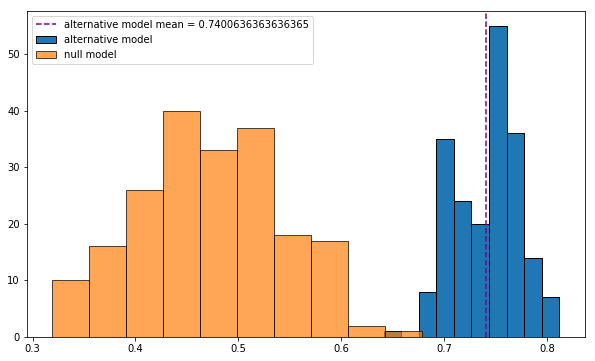

In [15]:
plt.figure(figsize=(10, 6))
plt.hist(rocs, edgecolor="black")
plt.hist(rocs_null, edgecolor="black", alpha=.7)
plt.axvline(rocs.mean(), ls="--", color="purple")
plt.legend(["alternative model mean = {}".format(rocs.mean()),"alternative model", "null model"])

In [7]:
pvalue = (np.sum(rocs_null >= np.mean(rocs)) + 1.0) / (n_iters + 1.0)
print(pvalue)

0.004975124378109453


# save everything

In [8]:
save_path = "results_with_nullmodel.h5py"

data_obj = dict(
    feat_idx=bools, 
    feat_imp=imps, 
    roc_score=rocs,
    null_feat_idx=bools_null,
    null_feat_imp=imps_null, 
    null_rocs=rocs_null
)

dts = [np.bool, np.float64, np.float64, np.bool, np.float64, np.float64]

print(h5_save(save_path, data_obj, dts))

('results_with_nullmodel.h5py', dict_keys(['feat_idx', 'feat_imp', 'roc_score', 'null_feat_idx', 'null_feat_imp', 'null_rocs']))


In [10]:
failed_idxs

[]